# Aircraft Engine RUL Prediction Using 1D Convolutional Neural Network and Piecewise Linear Degradation Model

In [22]:
import pandas as pd
import numpy as np
#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import mean_squared_error
import os
os.chdir("/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/CMaps/")
#for deep learning
import tensorflow.keras
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Activation, Masking, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks

1D CNN expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [3]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.    
        Number of batches = np.floor((len(input_data) - window_length)/shift) + 1    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.        
    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [2]:
def process_targets(data_length, early_rul=None):
    """ 
    Takes datalength and earlyrul as input and 
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape=(early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [5]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [6]:
train_data = pd.read_csv("/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/CMaps/train_FD001.txt", sep = "\s+", header = None)
test_data = pd.read_csv("/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/CMaps/test_FD001.txt", sep = "\s+", header = None)
true_rul = pd.read_csv('/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/CMaps/RUL_FD001.txt', sep = '\s+', header = None)
print(train_data.shape)
print(test_data.shape)
print(true_rul.shape)

(20631, 26)
(13096, 26)
(100, 1)


In [7]:
window_length = 30
shift = 1
early_rul = 125            
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.
# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length=window_length, shift=shift,
                                                             num_test_windows=num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


Training and validation split, We will take 20% of training data (sampled randomly) as our validation set. We will monitor the training of our model using the validation set

In [8]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size=0.2,
                                                                                                            random_state=83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 14)
Processed validation data shape:  (3547, 30, 14)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


In [13]:
def create_compiled_model():
    model = Sequential([
        Conv1D(256, 7, activation = "relu", input_shape = (window_length, processed_train_data.shape[2])),
        Conv1D(96, 7, activation = "relu"),
        Conv1D(32, 7, activation = "relu"),
        GlobalAveragePooling1D(),
        Dense(64, activation = "relu"),
        Dense(128, activation = "relu"),
        Dense(1)
    ])
    model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))
    return model

In [14]:
#use a learning rate scheduler that will decrease the learning rate after 10 epochs
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001

In [15]:
callback = callbacks.LearningRateScheduler(scheduler, verbose = 1)
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 30,
                    validation_data=(processed_val_data, processed_val_targets),
                    callbacks=callback, batch_size=64, verbose=2)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-10-25 11:50:40.682138: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-25 11:50:40.682274: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-10-25 11:50:41.302661: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-25 11:50:41.302841: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-25 11:50:41.472406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.


2022-10-25 11:50:46.868359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 - 6s - loss: 852.4087 - val_loss: 409.3155
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
222/222 - 3s - loss: 328.2444 - val_loss: 275.0764
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
222/222 - 2s - loss: 291.0820 - val_loss: 281.4438
Epoch 4/30

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
222/222 - 3s - loss: 257.6422 - val_loss: 237.6624
Epoch 5/30

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
222/222 - 3s - loss: 240.8479 - val_loss: 298.5452
Epoch 6/30

Epoch 00006: LearningRateScheduler reducing learning rate to 0.001.
222/222 - 3s - loss: 240.6565 - val_loss: 244.3852
Epoch 7/30

Epoch 00007: LearningRateScheduler reducing learning rate to 0.001.
222/222 - 2s - loss: 234.2700 - val_loss: 207.6176
Epoch 8/30

Epoch 00008: LearningRateScheduler reducing learning rate to 0.001.
222/222 - 2s - loss: 220.9605 - val_loss: 241.5081
Epoch 9/30

Epoch 00009: Learnin

Let's plot the loss

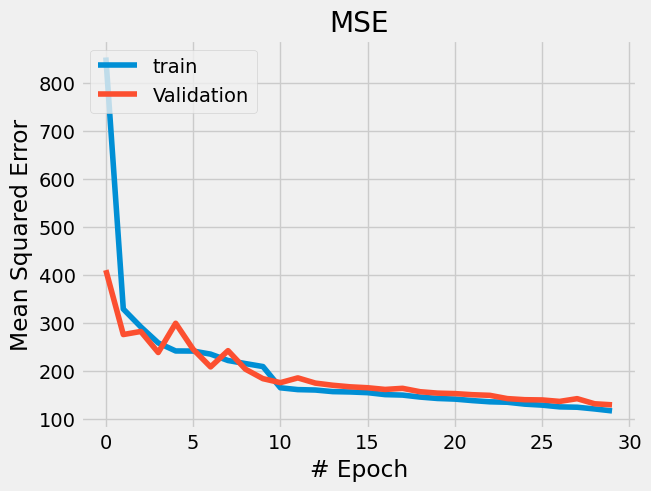

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

Why did we run the model only for 30 epochs, even though the validation loss seems to be decreasing? Well, while training this model for more epochs, we previously observed that it is possible to decrease the validation loss to a very small number. But in that case, our actual test loss is not that great. This is because our model is overfitting the validation dataset. So to get a good test performance, we should stop our training at an intermediate value of the validation loss. We chose 30 epochs as that gives a good enough test error.

### Results on Train Set

In [18]:
scores = model.evaluate(processed_train_data, processed_train_targets, verbose=1, batch_size=200)
print('MSE: {}'.format(scores))

71/71 [==============================] - 1s 8ms/step - loss: 113.6483
MSE: 113.6482925415039


### Results on Test Set

In [23]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

RMSE:  16.107787837086878


In [40]:
#We will now compute the RMSE by taking only last example of each engine.
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]
RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  16.546352281159333


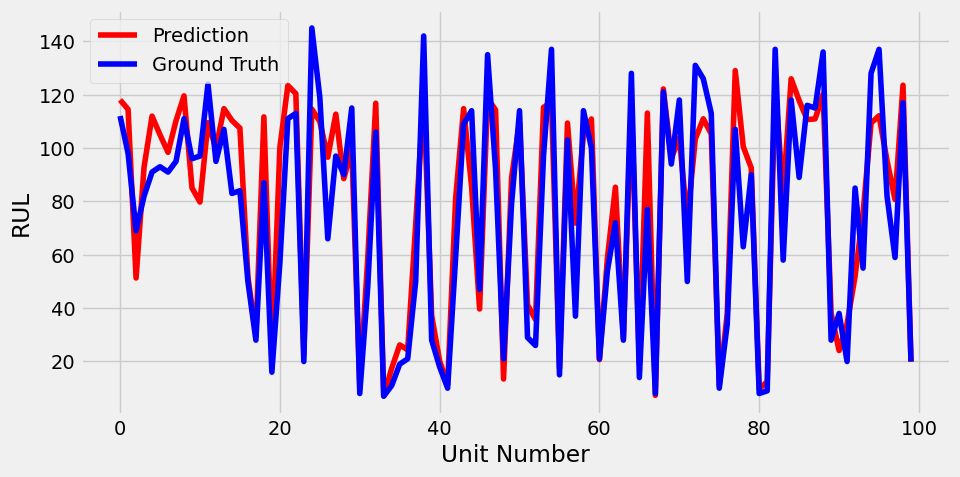

In [43]:
plt.figure(figsize=(10,5))
plt.plot(mean_pred_for_each_engine, color='red', label='Prediction')
plt.plot(true_rul, color='blue', label='Ground Truth')
plt.ylabel("RUL")
plt.xlabel("Unit Number")
plt.legend(loc='upper left')
plt.show()

S-score:  493.3831768087961


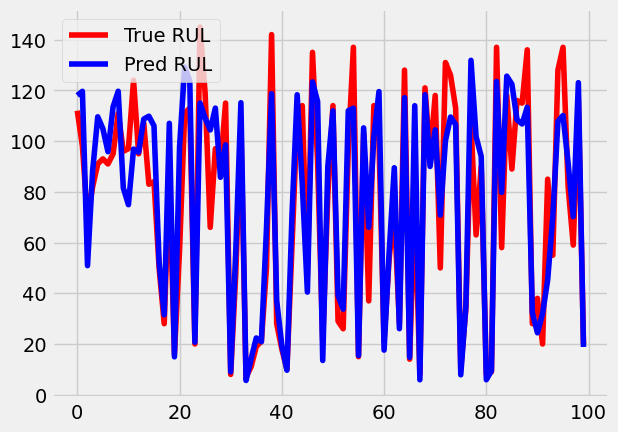

In [42]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))
    
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)
# Plot true and predicted RUL values
plt.plot(true_rul, label="True RUL", color="blue")
plt.plot(preds_for_last_example, label="Pred RUL", color="red")
plt.legend()
plt.show()